In [55]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

## Initial analysis

In [56]:
dataframe = pd.read_csv('../data/wfp_food_prices_nga.csv')
dataframe.head()

,date,state,city,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,2002-01-15,Katsina,Jibia,Jibia (CBM),13.08,7.24,cereals and tubers,Maize,KG,actual,Wholesale,NGN,175.92,1.5525
1,2002-01-15,Katsina,Jibia,Jibia (CBM),13.08,7.24,cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254
2,2002-01-15,Katsina,Jibia,Jibia (CBM),13.08,7.24,cereals and tubers,Rice (imported),KG,actual,Wholesale,NGN,358.70,3.1656
3,2002-01-15,Katsina,Jibia,Jibia (CBM),13.08,7.24,cereals and tubers,Sorghum,KG,actual,Wholesale,NGN,155.61,1.3733
4,2002-01-15,Katsina,Jibia,Jibia (CBM),13.08,7.24,pulses and nuts,Beans (niebe),KG,actual,Wholesale,NGN,196.87,1.7374


## Exclude columns and create code column to facilitate query of series

In [57]:
dataframe = dataframe.drop(columns=['latitude', 'longitude'])
dataframe = dataframe[dataframe['priceflag'] != 'forecast']
dataframe['series_id'] = dataframe[['state', 'city', 'market', 'category', 'commodity', 'unit']].astype(
    'category').apply(lambda x: '_'.join(x), axis=1)
#cat.codes create unique id
dataframe['series_id'] = dataframe['series_id'].astype('category').cat.codes
dataframe.head()


,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,175.92,1.5525,543
1,2002-01-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544
2,2002-01-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Rice (imported),KG,actual,Wholesale,NGN,358.70,3.1656,545
3,2002-01-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Sorghum,KG,actual,Wholesale,NGN,155.61,1.3733,546
4,2002-01-15,Katsina,Jibia,Jibia (CBM),pulses and nuts,Beans (niebe),KG,actual,Wholesale,NGN,196.87,1.7374,548


In [58]:
for col in dataframe.columns:
    print(col)
    print(f'Number of unique values {len(dataframe[col].unique())}')
    print(f'Number of NAN values {dataframe[col].isna().sum()}')
    print('-----------------------------------------------------')

date
Number of unique values 258
Number of NAN values 0
-----------------------------------------------------
state
Number of unique values 14
Number of NAN values 0
-----------------------------------------------------
city
Number of unique values 31
Number of NAN values 0
-----------------------------------------------------
market
Number of unique values 40
Number of NAN values 0
-----------------------------------------------------
category
Number of unique values 8
Number of NAN values 0
-----------------------------------------------------
commodity
Number of unique values 42
Number of NAN values 0
-----------------------------------------------------
unit
Number of unique values 22
Number of NAN values 0
-----------------------------------------------------
priceflag
Number of unique values 3
Number of NAN values 0
-----------------------------------------------------
pricetype
Number of unique values 2
Number of NAN values 0
-----------------------------------------------------

### Get a one commodity and plot series

In [59]:
filter = (dataframe['series_id'] == 543)
dataframe_plot = dataframe[filter]
dataframe_plot

,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,175.92,1.5525,543
10,2002-02-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,169.76,1.4826,543
15,2002-03-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,181.94,1.5767,543
24,2002-04-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,190.22,1.6441,543
34,2002-05-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,208.67,1.7982,543
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10330,2016-10-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,196.00,0.6424,543
10774,2016-11-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,199.00,0.6317,543
11844,2017-01-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,185.00,0.6063,543
12273,2017-02-15,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,190.00,60.5096,543


In [60]:
px.line(dataframe_plot, x='date', y='price', title='Series of Maize price in Jibia in Jibia (CBM) using NGN currency')

In [61]:
px.line(dataframe_plot, x='date', y='usdprice', title='Series of Maize price in Jibia in Jibia (CBM) using Dolar')


### Time series has problem, not full continues data 
* Drop
* Rebuild series (moving average or other technic)


In [62]:
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe['date'] = dataframe['date'].apply(lambda x: x.replace(day=1))
dataframe

,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,175.92,1.5525,543
1,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544
2,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Rice (imported),KG,actual,Wholesale,NGN,358.70,3.1656,545
3,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Sorghum,KG,actual,Wholesale,NGN,155.61,1.3733,546
4,2002-01-01,Katsina,Jibia,Jibia (CBM),pulses and nuts,Beans (niebe),KG,actual,Wholesale,NGN,196.87,1.7374,548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67027,2023-01-01,Zamfara,Kaura Namoda,Kaura Namoda,pulses and nuts,Cowpeas (brown),KG,aggregate,Retail,NGN,298.55,0.6480,1023
67028,2023-01-01,Zamfara,Kaura Namoda,Kaura Namoda,pulses and nuts,Cowpeas (white),100 KG,aggregate,Wholesale,NGN,29440.00,63.8992,1024
67029,2023-01-01,Zamfara,Kaura Namoda,Kaura Namoda,pulses and nuts,Cowpeas (white),KG,aggregate,Retail,NGN,274.82,0.5965,1025
67030,2023-01-01,Zamfara,Kaura Namoda,Kaura Namoda,pulses and nuts,Groundnuts (shelled),100 KG,aggregate,Wholesale,NGN,46960.00,101.9261,1026


In [63]:
def data_is_continuos(df):
    df = df.sort_values(by='date')
    df['diff'] = df['date'].diff()
    is_continuous = df['diff'].iloc[1:].nunique() == 1
    return is_continuous


def get_incomplete_series(dataframe):
    dataframe_continuos = {
        'SerieCod': [],
        'DataContinuity': [],
        'DataPoints': []
    }
    for cod in dataframe['series_id'].unique():
        dataframe_to_check = dataframe[dataframe['series_id'] == cod]
        dataframe_continuos['SerieCod'].append(dataframe_to_check['series_id'].iloc[0])
        dataframe_continuos['DataContinuity'].append(data_is_continuos(dataframe_to_check))
        dataframe_continuos['DataPoints'].append(len(dataframe_to_check['date'].unique()))
    return pd.DataFrame(dataframe_continuos)


dataframe_continuo = get_incomplete_series(dataframe)
dataframe_continuo

,SerieCod,DataContinuity,DataPoints
0,543,False,122
1,544,False,123
2,545,False,123
3,546,False,125
4,548,False,12
...,...,...,...
1023,640,False,32
1024,728,False,33
1025,915,False,33
1026,1017,False,33


In [64]:
px.histogram(dataframe_continuo['DataPoints'], title='Distribuition of number of datapoints',
             color=dataframe_continuo['DataContinuity'])

### Another problem besides continuity is the number of data point nothing series
To get around this problem, all series to continue in the dataframe must have at least 12 date points, which allows us to adjust if it does not continue and we can make some prediction

In [65]:
cod_to_drop = dataframe_continuo[dataframe_continuo['DataPoints'] < 12]['SerieCod'].to_list()
print(cod_to_drop)

[656, 554, 547, 352, 420, 452, 469, 451, 914, 727, 145, 147, 148, 151, 156, 157, 160, 161, 163, 164, 165, 146, 149, 150, 152, 153, 154, 155, 158, 159, 162, 19, 71, 410, 395]


In [66]:
dataframe = dataframe[~dataframe['series_id'].isin(cod_to_drop)]
dataframe.head()

,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Maize,KG,actual,Wholesale,NGN,175.92,1.5525,543
1,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544
2,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Rice (imported),KG,actual,Wholesale,NGN,358.70,3.1656,545
3,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Sorghum,KG,actual,Wholesale,NGN,155.61,1.3733,546
4,2002-01-01,Katsina,Jibia,Jibia (CBM),pulses and nuts,Beans (niebe),KG,actual,Wholesale,NGN,196.87,1.7374,548


### Adjust series using average mean to populate

In [67]:
dataframe_to_adjust = dataframe[dataframe['series_id'] == 544].reset_index(drop=True)
dataframe_to_adjust

,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2016-10-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,189.00,0.6194,544
119,2016-11-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,126.00,0.4000,544
120,2017-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,193.00,0.6325,544
121,2017-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,202.00,64.3312,544


In [68]:
px.line(dataframe_to_adjust, x='date', y='price', title='Series of series_id 544')

In [69]:
dataframe_adjusted = dataframe_to_adjust.copy()

dataframe_adjusted = dataframe_adjusted.set_index('date',drop=True)

# Criar um intervalo completo de datas, no caso, mensal
full_index = pd.date_range(start=dataframe_adjusted.index.min(), end=dataframe_adjusted.index.max(), freq='MS')
dataframe_adjusted = dataframe_adjusted.reindex(full_index)
dataframe_adjusted.index.name = 'date'
dataframe_adjusted.reset_index(inplace=True)
dataframe_adjusted

,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544.0
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544.0
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544.0
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544.0
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,2016-11-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,126.00,0.4000,544.0
179,2016-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,2017-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,193.00,0.6325,544.0
181,2017-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,202.00,64.3312,544.0


In [70]:
columns_to_fill = [col for col in dataframe_adjusted.columns if col not in ['usdprice', 'price']]
dataframe_adjusted_mean = dataframe_adjusted.copy()
# Preencher valores faltantes com o valor anterior
dataframe_adjusted_mean[columns_to_fill] = dataframe_adjusted_mean[columns_to_fill].fillna(method='ffill')

expanding_mean = dataframe_adjusted_mean['price'].expanding().mean()
dataframe_adjusted_mean['price'] = dataframe_adjusted_mean['price'].combine_first(expanding_mean)

expanding_mean = dataframe_adjusted_mean['usdprice'].expanding().mean()
dataframe_adjusted_mean['usdprice'] = dataframe_adjusted_mean['usdprice'].combine_first(expanding_mean)
dataframe_adjusted_mean.head()


C:\Users\siera\AppData\Local\Temp\ipykernel_14892\1503865728.py:4: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544.0
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544.0
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544.0
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544.0
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544.0


In [71]:
dataframe_adjusted_rolling_12_months = dataframe_adjusted.copy()

rolling_mean_price_12_months = dataframe_adjusted_rolling_12_months['price'].rolling(window=12).mean()
rolling_mean_usdprice_12_months = dataframe_adjusted_rolling_12_months['usdprice'].rolling(window=12).mean()

# Preencher valores NaN com a média móvel
dataframe_adjusted_rolling_12_months['price'] = dataframe_adjusted_rolling_12_months['price'].combine_first(rolling_mean_price_12_months)
dataframe_adjusted_rolling_12_months['usdprice'] = dataframe_adjusted_rolling_12_months['usdprice'].combine_first(rolling_mean_usdprice_12_months)

# Se houver NaNs restantes, preenchê-los com o valor anterior
dataframe_adjusted_rolling_12_months = dataframe_adjusted_rolling_12_months.fillna(method='ffill')
dataframe_adjusted_rolling_12_months.head()

C:\Users\siera\AppData\Local\Temp\ipykernel_14892\2171362633.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544.0
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544.0
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544.0
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544.0
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544.0


In [72]:
dataframe_adjusted_rolling_6_months = dataframe_adjusted.copy()

rolling_mean_price_6_months = dataframe_adjusted_rolling_6_months['price'].rolling(window=6).mean()
rolling_mean_usdprice_6_months = dataframe_adjusted_rolling_6_months['usdprice'].rolling(window=6).mean()

# Preencher valores NaN com a média móvel
dataframe_adjusted_rolling_6_months['price'] = dataframe_adjusted_rolling_6_months['price'].combine_first(rolling_mean_price_6_months)
dataframe_adjusted_rolling_6_months['usdprice'] = dataframe_adjusted_rolling_6_months['usdprice'].combine_first(rolling_mean_usdprice_6_months)

# Se houver NaNs restantes, preenchê-los com o valor anterior
dataframe_adjusted_rolling_6_months = dataframe_adjusted_rolling_6_months.fillna(method='ffill')
dataframe_adjusted_rolling_6_months.head()

C:\Users\siera\AppData\Local\Temp\ipykernel_14892\2163955772.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544.0
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544.0
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544.0
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544.0
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544.0


In [73]:
dataframe_adjusted_rolling_3_months = dataframe_adjusted.copy()

rolling_mean_price_3_months = dataframe_adjusted_rolling_3_months['price'].rolling(window=3).mean()
rolling_mean_usdprice_3_months = dataframe_adjusted_rolling_3_months['usdprice'].rolling(window=3).mean()

# Preencher valores NaN com a média móvel
dataframe_adjusted_rolling_3_months['price'] = dataframe_adjusted_rolling_3_months['price'].combine_first(rolling_mean_price_3_months)
dataframe_adjusted_rolling_3_months['usdprice'] = dataframe_adjusted_rolling_3_months['usdprice'].combine_first(rolling_mean_usdprice_3_months)

# Se houver NaNs restantes, preenchê-los com o valor anterior
dataframe_adjusted_rolling_3_months = dataframe_adjusted_rolling_3_months.fillna(method='ffill')
dataframe_adjusted_rolling_3_months.head()

C:\Users\siera\AppData\Local\Temp\ipykernel_14892\3923492025.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544.0
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544.0
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544.0
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544.0
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544.0


In [74]:
dataframe_adjusted_interpolate = dataframe_adjusted.copy()
dataframe_adjusted_interpolate.set_index('date',inplace=True)
rolling_mean_price_interpolate = dataframe_adjusted_interpolate['price'].interpolate(method='slinear')
rolling_mean_usdprice_interpolate = dataframe_adjusted_interpolate['usdprice'].interpolate(method='slinear')

# Preencher valores NaN com a média móvel
dataframe_adjusted_interpolate['price'] = dataframe_adjusted_interpolate['price'].combine_first(rolling_mean_price_interpolate)
dataframe_adjusted_interpolate['usdprice'] = dataframe_adjusted_interpolate['usdprice'].combine_first(rolling_mean_usdprice_interpolate)

# Se houver NaNs restantes, preenchê-los com o valor anterior
dataframe_adjusted_interpolate = dataframe_adjusted_interpolate.fillna(method='ffill').reset_index()
dataframe_adjusted_interpolate.head()

C:\Users\siera\AppData\Local\Temp\ipykernel_14892\585883261.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



,date,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
0,2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18,1.3254,544.0
1,2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54,1.2973,544.0
2,2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00,1.5165,544.0
3,2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50,1.6206,544.0
4,2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12,1.6815,544.0


In [75]:
# Criar a figura
fig = go.Figure()

# Adicionar traços para cada DataFrame
fig.add_trace(go.Scatter(x=dataframe_to_adjust['date'], y=dataframe_to_adjust['price'], mode='lines', name='Raw dataset'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_mean['date'], y=dataframe_adjusted_mean['price'], mode='lines', name='Mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_rolling_12_months['date'], y=dataframe_adjusted_rolling_12_months['price'], mode='lines', name='12 months Rolling mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_rolling_6_months['date'], y=dataframe_adjusted_rolling_6_months['price'], mode='lines', name='6 months Rolling mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_rolling_3_months['date'], y=dataframe_adjusted_rolling_3_months['price'], mode='lines', name='3 months Rolling mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_interpolate['date'], y=dataframe_adjusted_interpolate['price'], mode='lines', name='Interpolate'))

# Adicionar título e rótulos dos eixos
fig.update_layout(title='Multiple approaches to overwrite NAN',
                  xaxis_title='Date',
                  yaxis_title='Price')

# Mostrar o gráfico
fig.show()


In [76]:
fig = go.Figure()

# Adicionar traços para cada DataFrame
fig.add_trace(go.Scatter(x=dataframe_to_adjust['date'], y=dataframe_to_adjust['usdprice'], mode='lines', name='Raw dataset'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_mean['date'], y=dataframe_adjusted_mean['usdprice'], mode='lines', name='Mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_rolling_12_months['date'], y=dataframe_adjusted_rolling_12_months['usdprice'], mode='lines', name='12 months Rolling mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_rolling_6_months['date'], y=dataframe_adjusted_rolling_6_months['usdprice'], mode='lines', name='6 months Rolling mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_rolling_3_months['date'], y=dataframe_adjusted_rolling_3_months['usdprice'], mode='lines', name='3 months Rolling mean adjust'))
fig.add_trace(go.Scatter(x=dataframe_adjusted_interpolate['date'], y=dataframe_adjusted_interpolate['usdprice'], mode='lines', name='Interpolate'))
# Adicionar título e rótulos dos eixos
fig.update_layout(title='Multiple approaches to overwrite NAN',
                  xaxis_title='Date',
                  yaxis_title='Value')

# Mostrar o gráfico
fig.show()


### Result
I was able to recover the points that were missing values using strategies such as interpolation, simple average, and moving average. However, these methods did not produce a natural effect on the series, often resulting in peak points that appear too linear.
### Next step
To analyze the behavior of the series mentioned above, I chose to use interpolation for the analysis. I will plot the PACF and ACF graphs to assess how important the past is in predicting the future.

In [77]:
dataframe_adjusted_interpolate.set_index('date',inplace=True,drop=True)
dataframe_adjusted_interpolate

,state,city,market,category,commodity,unit,priceflag,pricetype,currency,price,usdprice,series_id
date,,,,,,,,,,,,
2002-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,150.18000,1.325400,544.0
2002-02-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,148.54000,1.297300,544.0
2002-03-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,175.00000,1.516500,544.0
2002-04-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,187.50000,1.620600,544.0
2002-05-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,195.12000,1.681500,544.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,126.00000,0.400000,544.0
2016-12-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,158.95082,0.514344,544.0
2017-01-01,Katsina,Jibia,Jibia (CBM),cereals and tubers,Millet,KG,actual,Wholesale,NGN,193.00000,0.632500,544.0


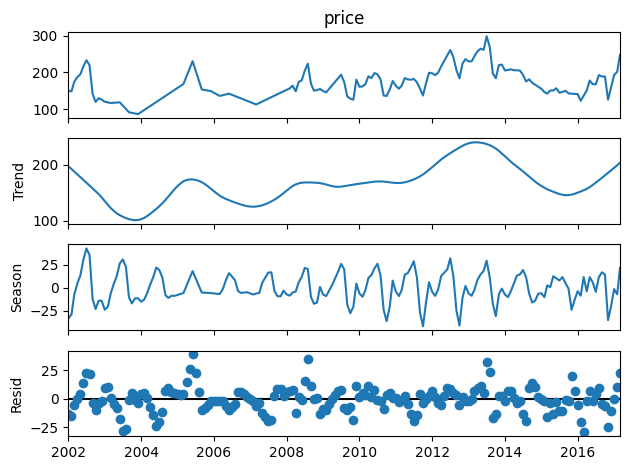

In [78]:
res = STL(dataframe_adjusted_interpolate['price']).fit()
res.plot()
plt.show()

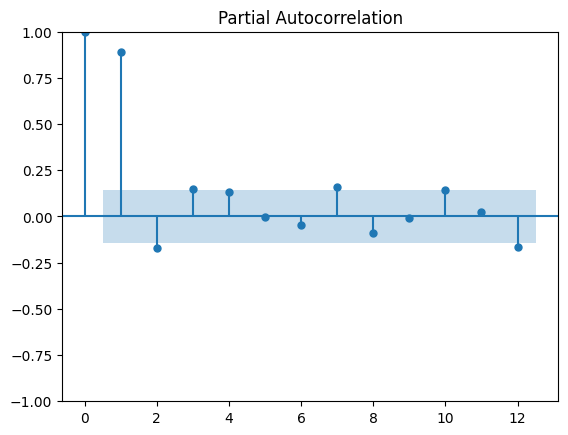

In [79]:
sm.graphics.tsa.plot_pacf(dataframe_adjusted_interpolate['price'], lags=12)
plt.show()

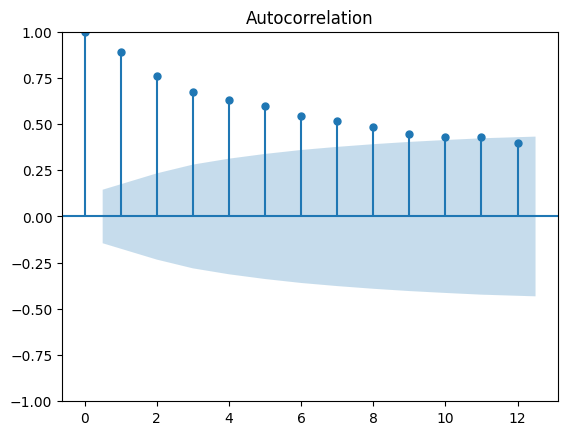

In [80]:
sm.graphics.tsa.plot_acf(dataframe_adjusted_interpolate['price'], lags=12)
plt.show()